# Laboratory 09 -  Long Term Short Term Neural Networks

While CNN's are a special type of feed-forward network that is able to capture spatial dependencies in our input, many real-world problems have inputs with dependencies that are spread across time. That is, the data is (or can be) logically organized as a sequence or in time steps. Just like CNN's are able to capture spatial dependencies, recurrent neural networks (or simply RNN's) are able capture sequence dependencies.  

One type of sequence problem that is of special interest to financial computing, is forecasting. And among the forecasting problems, stock price prediction is one of most difficult and fun. We previously attempted this problem in our very first lab, obtaining surprisingly good results. However, those results were extremely misleading in that they were strongly dependent on the specific stock trend and the choice of hyper-parameters. In this lab we're going to tackle the problem again. But this time we're going to bring in the big guns. :) That is, we're going to use an LSTM recurrent neural network in a sequence to vector configuration. 

Without further ado here are the imports you we'll need:

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
!pip install yfinance
import numpy as np
import yfinance as yf 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn
import torch.nn.functional as F

import helper

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Exercise 1

First thing, first. We need data to work with. So, for comparison purpose we can use the same data as in the first lab, namely: historical data for Microchip Corp. Complete the TODO's below to get and view the day by day stock closing price for the 'MCHP' ticker from 2010-01-01 to 2021-01-01 using `yfinance` API.

(2769,)


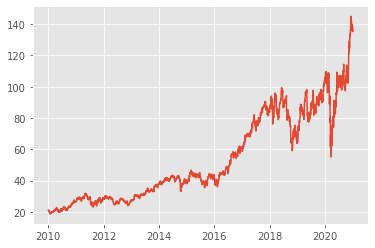

In [ ]:
# TODO 1.1: Get stock information
stock = yf.Ticker('MCHP')

# TODO 1.2: Get the close day prices from 2010-01-01 until 2021-01-01
mchp = stock.history(start="2010-01-01",  end="2021-01-01", interval='1d')['Close']
print(mchp.shape)
# TODO 1.3: Plot the colse price trend
plt.plot(mchp)

As usual, to make the neural network training more stable we need to normlize our data. Use a `MinMaxScaler` to bring the data in the range \[ 0, 1\].

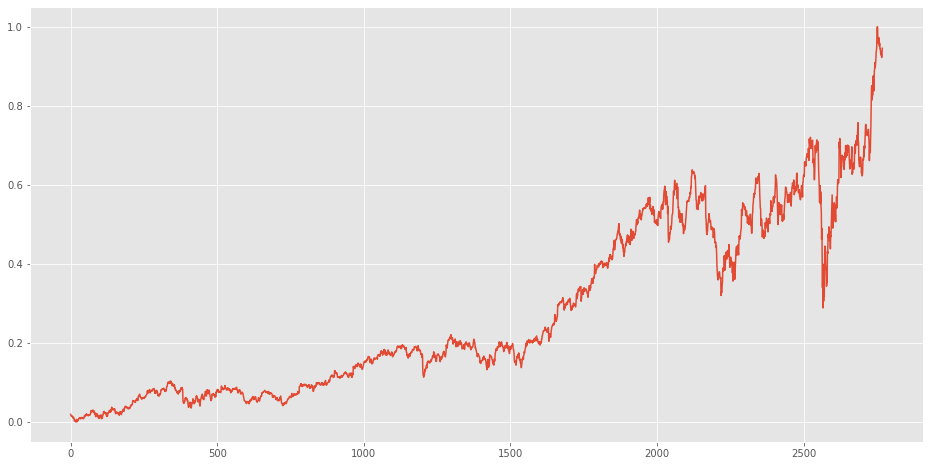

In [ ]:
# TODO 1.4: instantiate a standard MinMax scaller
scaler = MinMaxScaler()

# TODO 1.5: Scale the close prices and save them as a numpy array
mchp_normalized = scaler.fit_transform(mchp.values.reshape(-1, 1))


# Ploting the scaled trend (it should be between 0 and 1)
plt.figure(figsize=(16, 8))
plt.plot(mchp_normalized)


### Exercise 2

Similarly to the Character-Level LSTM from the class notebooks, you need to transform the data such that it is organized in mini-batches of proper sequences length.  Moreover, the data must be split at least in train and test sets such that the training-validation loop can be implemented.

Different from the Character-Level LSTM, here we want to forecast the stock prices for each day, a number of days in the future. To create the proper sequences, we need to use a sliding window of sequence length + 1 such that we can generate both features and targets. For example, setting up the forecast period to 30 days out, means that our feature sequence length is 30 days, while our target is the value from day 31. Hence, the sliding window size is 31 in this example.

After parsing the data in this way, you can simply truncate and reshape the features and targets to obtain batches of specified sequence length. In turn, these can then be passed to a train/test split function such that we can use our data in the training loop.

Follow the TODO's below to complete this task.

In [ ]:
# TODO 2.1: Implement make_batches to generate batches of specified size and sequence length
# Doesn't work, cause of teacher's implementation (and data changed).
def make_batches(data, batch_size, seq_len):
    # TODO 2.1.1: Make sequences of length window_size
    print(data.shape)
    window_size = seq_len + 1
    #seq_data = np.array_split(data, (len(data) // window_size) + 1)
    seq_data = []
    j = 0
    while True:
      seq_data.append(data[j:j + window_size])
      j += window_size
      if j > len(data):
        break
    
    #seq_data = seq_data.reshape(90, -1)
    #seq_data = [seq_data[i,0].squeeze()[0] for i in range(len(seq_data))]
    #print(len(seq_data[0]))

    # TODO 2.1.2: Select features (nseq, seq_len, nfeatures) and targets (nseq, 1) for each sequence
    x = [seq[:seq_len] for seq in seq_data]
    y = [seq[-1] for seq in seq_data]

    # TODO 2.1.3: Compute the total number of batches
    n_batches = len(data) // batch_size
    
    # TODO 2.1.4: Keep only enough points to make full batches for x, y
    points_to_remove = len(data) - (n_batches * batch_size)
    print(points_to_remove)
    # 1 point to remove only
    x[-1] = x[-1][:-points_to_remove]
    y = y

    print(len(x[0]))
   
    # TODO 2.1.5: Reshape x, y in batch_size rows
    x = np.reshape(x, (batch_size, -1)).T
    y = np.reshape(y, (batch_size, -1)).T

    return x, y

# TEST CODE: This should pass without any error
x, y = make_batches(mchp_normalized, 16, 30)
assert(x.shape == (171, 16, 30, 1))
assert(y.shape == ((171, 16, 1)))

In [ ]:
# TODO 2.2: Implement train_test_split to generate batched train and test sets
# Doesn't work, cause of teacher's implementation (and data changed).
def train_test_split(x, y, test_size):
    
    # TODO 2.2.1: Set the total number of batches either from x or y shape
    nbatches = x.shape[0]

    # TODO 2.2.2: Compute training set size
    train_size = int(np.floor((1 - test_size) * nbatches))
    
    # TODO 2.2.3: Compute training split index
    indices = list(range(nbatches))
    train_idx = indices[:train_size]

    # TODO 2.2.4: Compute x_train, y_train and transform to tensors of type "torch.Tensor"
    x_train = torch.tensor(x[train_idx])
    y_train = torch.tensor(y[train_idx])
    
    # TODO 2.2.5: Aggeregate x_train, y_train as a list
    trainset = np.concatenate(x_train, y_train, axis = 1)
    
     # TODO 2.2.6: Do the same for x_test, y_test and testset list
    test_idx = indices[train_size:]
    x_test = torch.tensor(x[test_idx])
    y_test = torch.tensor(x[test_idx])
    testset = np.concatenate(x_train, y_train, axis = 1)
    
    return trainset, testset

# TEST CODE: This should pass without any error
trainset, testset = train_test_split(x, y, 0.2)
assert(len(trainset) == 2)
assert(len(testset) == 2)
assert(trainset[0].shape == torch.Size([137, 16, 30, 1]))
assert(trainset[1].shape == torch.Size([137, 16, 1]))
assert(testset[0].shape == torch.Size([34, 16, 30, 1]))
assert(testset[1].shape == torch.Size([34, 16, 1]))

### Exercise 3

The next step is to build our LSTM based network architecture. As a reminder the [LSTM API](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) in PyThorch `nn` module has a number of parameters, of which the most relevant are:
- **input_size** represents the number of features in the input, i.e. input dimension
- **hidden_size** represents the number of units in the hidden layer i.e. hidden dimension
- **num_layers** represents the number recurrent layers
- **batch_first** represent the format of the input data, if True the expected data must be formatted as (batch_size, seq_len, num_features)
- **dropout** represents the dropout probability for dropout layers automatically introduced between LSTM layers. If set to zero no dropout is used.

Aside from these, we still need a regression layer to take features generated by the LSTM and transform them to the desired output price prediction. Hence, we also need to specify the output dimension. Note that for our problem this will be 1, since we want to predict a single price for each input sequence.

We also need to provide the initial hidden states, which are tensors with format `(num_layers, batch_size, hidden_size)`. So you will need to implement a hidden state initialization method to create the two tensors.

Finally, you need to implement the `forward()` method such that the network will work as a sequence-to-vector architecture and it will only backprop up to the initial state for each batch (not through the entire history from batch to batch). The first is accomplished by simply selecting only the last recurrent output in the from the LSTM layer. Whereas the second can be accomplished in several ways. In the Character-Level LSTM from the class notebook, we have done this by always creating new variables for the hidden state. However there is a much easier way to do this, namely: using the [`detach()`](https://pytorch.org/docs/stable/autograd.html#torch.Tensor.detach) method. This method simply detaches the initial hidden states from the hole graph, making backpropagation through time treat them as constants. 

Follow the TODO's below to implement the network architecture.

In [ ]:
# TODO 3: Implement the LSTM network
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob = 0.5):
        super(Net, self).__init__()
        # TODO 3.1: Save the internal attributes
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # TODO 3.2: Instantiate the lstm with dropout_prob and batch_first=True
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_prob)
        
        # TODO 3.3: Instantiate the linear readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # TODO 3.4: Instantiate a dropout layer
        self.dropout = nn.Dropout(drop_prob)
    
    def init_hidden(self, batch_size):
        # TODO 3.5: Create initial zero long term (c0) and short term memory (h0) states
        #       Do not forget to tell pytorch that these states require gradient computation        
        h0 = torch.zeros((self.num_layers, batch_size, self.hidden_dim), requires_grad = True)
        c0 = torch.zeros((self.num_layers, batch_size, self.hidden_dim), requres_grad = True)
        
        h0 = h0.to(device)
        c0 = c0.to(device)
        return h0, c0
        
    def forward(self, x):
        # TODO 3.5: Create the initial memory states through init_hidden() and x.shape 
        h0, c0 = init_hidden()
        
        # TODO 3.6: Compute the recurrent output and hidden states.
        # Note: We don't want to back-propagate the hidden state through the hole input history.
        #       That is, you must BPTT upto the initial state for the current batch.
        #       Thus, you must tell pytorch to treat the h0 and c0 as constants by using detach()
        #       thereby truncating gradient computation upto the sequence length 
        r_out, (hn, cn) = self.lstm(ho, x)
        
        # TODO 3.7: We are intrested only in the single price prediction after sequnce length steps,
        #       i.e. the type of the problem is seq-to-vector or many-to-one.
        #       So, please select only the last outputs in the sequence for every point in the batch.
        r_out = r_out[:, :, -1]
        
        # TODO 3.8: Now apply the dropout layer
        out = self.dropout(r_out) 
        
        # TODO 3.9: Readout the result through the linear layer
        out = self.fc(out)
        
        return out

### Exercise 4

Finally its time for train our network. This will be no different from the usual implementation you are already used to. Here are the definitions of hyper-parameters:

In [ ]:
batch_size = 64 # the mini-batch size
seq_len = 14 # the sequence length -> setting forecast period
learning_rate = 0.0002 # training loop learning rate
test_size = 0.1 # the percentage of data to be used for testing

input_dim = 1 # the number of features in the input, here we have only one value
hidden_dim = 200 # the size of the hidden layer
num_layers = 2 # the number of reccurent layers
output_dim = 1 # the size of the output, here we have only one value -> the price
dropout_prob = 0.3 # dropout probability 

Now the first thing you will have to do is create the necessary components for training:
- generate batches of specified sequence length
- generate training and test sets
- instantiate the model, criterion and optimizer

Recall, that this is a regression problem so the criterion is MSE loss, whereas for the optimizer you can still use Adam.

In [ ]:
# TODO 4.1: Make the bacthes out of the normalized data
x, y = make_batches(mchp_normalized, batch_size, seq_len)

# TODO 4.2: Create the train/test sets
trainset, testset = train_test_split(x, y, test_size)

# TODO 4.3: Instantiate your model and move it to the appropiate device
model = Net(input_dim, hidden_dim, num_layers, output_dim, dropout_prob)

# TODO 4.4: Instantiate the mean squared error loss
criterion = nn.MSELoss()

# TODO 4.5: Instantiate an Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Finally, implement the training/validation loop guts to see results you'll get.

**I bet your in for a treat!**

In [ ]:
epochs = 500
counter = 0

x_train = trainset[0]
y_train = trainset[1]

x_valid = testset[0]
y_valid = testset[1]

trainset_len = x_train.shape[0]*x_train.shape[1]
validset_len = x_valid.shape[0]*x_valid.shape[1]

valid_loss_min = np.Inf

for epoch in range(epochs):
    train_loss = 0
    for data, target in zip(x_train, y_train):
        counter += 1
        # TODO 4.6: Move the data and targets to the appropiate device
        data, target = torch.from_numpy(data).to(device), torch.from_numpy(target).to(device) 
    
        # TODO 4.7: Zero out the gradient
        net.zero_grad()
        
        # TODO 4.8: Compute the output
        output = net(data)
        
        # TODO 4.9: Compute the loss
        loss = criterion(output, target)
        
        # TODO 4.10: Compute the gradient
        loss.backward()
        
        # TODO 4.11: Update the weights
        opt.step()
        
        train_loss += loss.item()*batch_size
    
    valid_loss = 0
    model.eval()
    # TODO 4.12: Implement the validation loop
    with torch.no_grad():
        for data, target in zip(x_valid, y_valid):
            data, target = torch.from_numpy(data).to(device), torch.from_numpy(target).to(device)
            output = net(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * batch_size
    model.train()

    train_loss = train_loss / trainset_len
    valid_loss = valid_loss / validset_len
    
    if valid_loss <= valid_loss_min:
            helper.save_model(model, 'chepoint.pth')
            valid_loss_min = valid_loss
            
    print("Epoch: {}/{}.. ".format(epoch + 1, epochs),
          "Step: {}...".format(counter),
          "Training Loss: {:.5f}.. ".format(train_loss),
          "Validation Loss: {:.5f}.. ".format(valid_loss))

In [ ]:
# Getting targets and the predictions for the entire dataset (trainset + testset)
model = helper.load_model(model,'chepoint.pth')
model.to(device)
x_all_seq = torch.from_numpy(x.reshape((-1, seq_len, 1)),).type(torch.Tensor).to(device)
y_all_targets = y.reshape((-1, 1))
y_all_pred = model(x_all_seq).cpu()
y_all_pred = y_all_pred.detach().numpy()

In [ ]:
# Plotting the target and the predicted trends
plt.figure(figsize=(20, 10))
plt.plot(y_all_pred, label="Predictions")
plt.plot(y_all_targets, label="Targets")
plt.legend()
plt.show()

## **Disclaimer**

**This is lab is not meant to be used to make real world investments. While the results may seem exceptional, there are several reasons because of which this model will not work well. Some of them were deliberately and explicitly introduced in the code for this lab. What are they?**

In reality the stock prices are dependent on a lot more variables. Here, only the history closing price is taken into account, which is not really a reliable pattern. The price might drop fast if something would happen with the CEO of the company, for example.